# Other Play
The environment definition of the lever coordination game does not contain any labels for the levers that the agents have to select.<br/>
Because of this the game admits a set of symmetries: an arbitrary relabeling of payoff-equivalent levers will not change any outcome of the game (up to relabeling).<br/>

The instance of the lever coordination game we are using contains 9 levers with a payoff of 1. <br/>
The self-play/league-play agents perform admirably during training because they can coordinate on which of those 9 levers to select.<br/>
In effect, they can coordinate on how to break the symmetry of the game.<br/>
However, in zero-shot coordination there is no guarantee that the other self-play/league-play agents break this symmetry in the same way.<br/>
This is why these agents perform so poorly during test time. 

In [Hu, Hengyuan, et al. (2020)](https://arxiv.org/pdf/2003.02979.pdf), they propose the **other-play** learning rule for zero-shot coordination.<br/>
In other-play, agents are forced to train with players that are continuely breaking these symmetries in an arbitrary way. <br/>
By doing this, it aims to build agents that are robust to this arbitrary symmetry breaking phenomenon.

This notebook implements the other-play algorithm on top of a self-play agent. <br/>
Let's start with importing the required modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools

from env.lever_game import LeverGame
from util.logger import Logger
from util.render import Renderer
from agents.qlearning import QLearning
from agents.exploration import LinearDecay

defining some hyper-parameters

In [2]:
total_episodes = 5000     # number of episodes we're going to train for
population = 30          # number of agents we're going to train simultaneously

# e-greedy hyperparameters
epsilon_start = 1
epsilon_end = 0.01
decayed_by = 3 * total_episodes / 4

and initializing some self-play utility functions

In [3]:
def init_population(num_actions, population_size):
    players = []
    for _ in range(population_size):
        p = QLearning(1, num_actions)
        players.append(p)
    return players

In [4]:
def self_play_action(env, player, state, episode, strategy):
    # our player
    a1 = player.select_action(state, epsilon=strategy.get_epsilon(episode))
    
    # the clone
    a2 = player.select_action(state, epsilon=strategy.get_epsilon(episode))
    
    return (a1, a2)

In [5]:
def cross_play_testing(players):
    population_size = len(players)
    reward_matrix = np.zeros((population_size, population_size))
    
    state = 0
    
    for i1 in range(population_size):
        for i2 in range(i1):
            p1 = players[i1]
            p2 = players[i2]
            
            state = 0
            
            action = (p1.get_optimal_action(state), p2.get_optimal_action(state))
            _, r, _, _ = env.step(action)
            
            reward_matrix[i1,i2] = r
            
    # the reward matrix is symmetric
    reward_matrix = reward_matrix + np.transpose(reward_matrix)
    
    return reward_matrix

## Training & Testing (Zero-Shot Coordination)

The other-play learning rule is implemented on top of a self-play agent by arbitrarily breaking the symmetry of every agent at every training step. <br/>
In the lever coordination game the symmetry is arbitraly broken by randomly sampling a permutation of all the payoff-equivalent levers. 

In [6]:
def equivalence_permutation(env):
    actions = set(range(env.num_levers))
    encountered = set()
    
    permutation = np.arange(env.num_levers)
    
    for a in actions:
        if a not in encountered:
            # equivalence class of a
            idxs = np.nonzero(np.array(env.payoffs) == env.payoffs[a])[0]
            
            # randomly permute within this equivalence class
            perm = np.random.permutation(idxs)
            
            for c, v in enumerate(idxs):
                permutation[v] = perm[c]
                encountered.add(v)
        
    return permutation

The permutation $p_i$ is sampled independently for every agent $i$, at every training step. <br/>
The agent $i$ now 'acts' in the game where the levers are relabed according to $p_i$. 

Let's see how this agent performs in zero-shot coordination

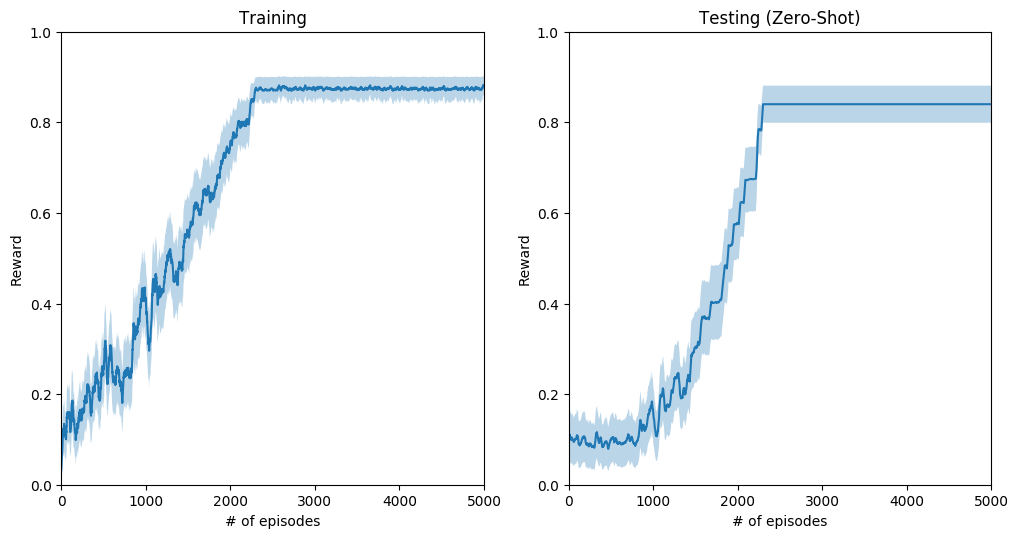

In [7]:
env = LeverGame()
log = Logger(population, total_episodes)

players = init_population(env.num_levers, population)
strategy = LinearDecay(epsilon_start, epsilon_end, decayed_by)

for episode in range(total_episodes):
    
    # Training
    for p in range(population):
        player = players[p]

        state = 0     # arbitrarily defined initial state

        # independently break the symmetry for each agent
        permutations = [equivalence_permutation(env), equivalence_permutation(env)]
        
        action = self_play_action(env, player, state, episode, strategy)

        # make sure the agents 'act' on their respective relabeled versions of the game
        relabeled_action = (permutations[0][action[0]], permutations[1][action[1]])
        observation, reward, done, info = env.step(relabeled_action)

        # our environment only has a single state
        next_state = state

        player.update_q_values(state, action[0], next_state, reward, done)

        # log training process
        _, r, _, _ = env.step((permutations[0][player.get_optimal_action(state)], permutations[1][player.get_optimal_action(state)]))
        log.update_training_log(p, episode, r)
            
    
    # Cross-play Testing
    rewards = cross_play_testing(players)
    
    log.update_testing_log(episode, rewards)
    
        
log.show_results(smoothness=20)

As we can see from the figure, the other-play agents manage to perform similarly during training and testing. <br/>
This is in stark contrast to the self-play and league-play agents, which performed well during training, but very poorly during test time.

### Agent Visualisation
Let's visualise the Q-values of our other-play agent to gain a better understanding of what it is learning

In [8]:
render_interval = int(total_episodes / 100)
file_name = 'other_play'

env = LeverGame()
player = QLearning(1, env.num_levers)
renderer = Renderer(total_episodes, player)
strategy = LinearDecay(epsilon_start, epsilon_end, decayed_by)

for episode in range(total_episodes):     
    state = 0     # arbitrarily defined initial state
    
    permutations = [equivalence_permutation(env), equivalence_permutation(env)]
    
    action = self_play_action(env, player, state, episode, strategy)

    # other-play action
    opa = (permutations[0][action[0]], permutations[1][action[1]])
    observation, reward, done, info = env.step(opa)

    # our environment only has a single state
    next_state = state

    player.update_q_values(state, action[0], next_state, reward, done)

    renderer.store_q_values(episode, player)

renderer.render_q_values(file_name, render_interval)

In [9]:
from IPython.display import Markdown as md

# Display the gif created above
md(f'![](gif/{file_name}.gif)')

![](gif/other_play.gif)

In contrast to the self-play and league-play agents, the other-play agent has learned a policy where it selects the lever with reward 0.9 every time. <br/>
Rather than going for a lever with a higher payoff, the other-play agent opts to go for the only unique lever in the game. <br/>
It has therefore managed to succesfully learn a policy that is robust when playing with novel partners not seen during training (zero-shot coordination) 